#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
import openpyxl
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re

#### Reading all the files in the Emotion_dataset folder (Excel and csv)

In [2]:
dataset_path = '../01.Emotion_dataset'

In [3]:
dataframes = []

for file in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, file)
    df = None
    if file.endswith(".csv"):
        df = pd.read_csv(file_path)
    elif file.endswith(".xlsx"):
        df = pd.read_excel(file_path, engine="openpyxl")
    
    if df is not None:
        dataframes.append(df)

In [4]:
df_all = pd.concat(dataframes, ignore_index=True)

In [5]:
df_all.head(10)

,example number,MailContent,Subject,EmotionLabel,Suggestion,suggestion type,Expectation,expectation type,Explanation,explanation type,...,replacement,LineItem,EmailAddress,SuggestionType,ExpectationType,ExplanationType,Replcement,ReplacedEmotionLabel,Generic,Unnamed: 0
0,1.0,I am writing to inform you that your job may b...,Redundancy email,Cold,"If you haven’t already done so, we suggest you...",Make it warmer,This is the type of news that should be commun...,Constructive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,We are still unsure which departments will be ...,NaN,Cold/distant,Should this information be decided upon before...,Make it warmer,This would help reduce anxiety amongst staff w...,Make it easer to take on board,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,We now want to meet with you to discuss this.,NaN,Formal,Before you move to discuss meeting your employ...,Make it transparent,This will reduce your employee’s anxiety and ...,Make it warmer,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,It’s regrettable but your role is one of the p...,NaN,Cold,We suggest you say you will consult with them...,Make it warmer,It’s important you reassure them that they wi...,Empowering,This sentence will make your employee feel anx...,Keep Alcon value in mind,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,But we now need to move forward.,NaN,Cold,"Also, could this employee consider possible a...",Make it more constructive,This would be more hopeful.,Hopeful,This sentence could really worry your employee...,Don't unnecessarily worry employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,We request you attend a meeting with HR on Mon...,NaN,Cold,It may be too early to have individual meeting...,Make it warmer,Perhaps suggest you will write to arrange an i...,Kinder,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.0,We look forward to hearing from you.,NaN,Final Remarks,We suggest below. We appreciate that this is ...,suggestion type 6,NaN,NaN,"Before you sign off, it’s important that you a...",Empowering,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3775 entries, 0 to 3774
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   example number          226 non-null    float64
 1   MailContent             3708 non-null   object 
 2   Subject                 3521 non-null   object 
 3   EmotionLabel            3704 non-null   object 
 4   Suggestion              3635 non-null   object 
 5   suggestion type         142 non-null    object 
 6   Expectation             3059 non-null   object 
 7   expectation type        92 non-null     object 
 8   Explanation             3039 non-null   object 
 9   explanation type        71 non-null     object 
 10  replcement              27 non-null     object 
 11  replaced emotion label  116 non-null    object 
 12  Generic (Yes/No)        195 non-null    object 
 13  Domain                  3735 non-null   object 
 14  Customer                3735 non-null   

In [7]:
df_all.shape

(3775, 26)

In [8]:
df_filtered = df_all[['MailContent', 'EmotionLabel']]
df_filtered

,MailContent,EmotionLabel
0,I am writing to inform you that your job may b...,Cold
1,We are still unsure which departments will be ...,Cold/distant
2,We now want to meet with you to discuss this.,Formal
3,It’s regrettable but your role is one of the p...,Cold
4,But we now need to move forward.,Cold
...,...,...
3770,We rely on each other to achieve our goals and...,Disappointed
3771,These paper IFUs were previously included in t...,Confusing
3772,This was a big undertaking for IT and in a sho...,Factual
3773,No one really needed it as we had paper manual...,Factual


## Data Preprocessing

#### Handling the null values

In [9]:
df_filtered_preprocessing = df_filtered.dropna()

In [10]:
df_filtered_preprocessing.isnull().sum()

MailContent     0
EmotionLabel    0
dtype: int64

In [11]:
df_filtered_preprocessing.shape

(3703, 2)

#### Handling the duplicate values

In [12]:
duplicateRows = df_filtered_preprocessing[df_filtered_preprocessing.duplicated()]

In [13]:
duplicateRows

,MailContent,EmotionLabel
30,We look forward to hearing from you.,Final Remarks
323,We have open permanent Production Associate po...,Detached
356,"If we had an award to give, you would certainl...",Confusing
357,Please accept my sincerest appreciation for th...,Formal
360,Participants will also be required to have a m...,Factual
...,...,...
3657,"As a result, they will spend ample time in con...",Confusing
3706,Here’s a sample of some topics that might get ...,Fine
3710,The employee’s working conditions and how he o...,Confusing
3717,The potential for growth/advancement,Fine


In [14]:
df_filtered_preprocessing = df_filtered_preprocessing.drop_duplicates()

In [15]:
df_filtered_preprocessing.shape

(3465, 2)

In [16]:
df_filtered_preprocessing

,MailContent,EmotionLabel
0,I am writing to inform you that your job may b...,Cold
1,We are still unsure which departments will be ...,Cold/distant
2,We now want to meet with you to discuss this.,Formal
3,It’s regrettable but your role is one of the p...,Cold
4,But we now need to move forward.,Cold
...,...,...
3770,We rely on each other to achieve our goals and...,Disappointed
3771,These paper IFUs were previously included in t...,Confusing
3772,This was a big undertaking for IT and in a sho...,Factual
3773,No one really needed it as we had paper manual...,Factual


In [17]:
df_filtered_preprocessing.to_csv('fullDataSet.csv', index = False)

#### pre-process the MailContent

In [18]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(sentence):
  sentence=str(sentence)
  sentence = sentence.lower()
  sentence=sentence.replace('{html}',"")
  cleanr = re.compile('<.*?>')  #for the HTML tags
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext)  #for URLs
  rem_num = re.sub('[0-9]+', '', rem_url) #for Numbers
  tokenizer = RegexpTokenizer(r'\w+') #tokenizing the words
  tokens = tokenizer.tokenize(rem_num)
  filtered_words = [word for word in tokens if not word in stopwords.words('english')]
  #stem_words=[stemmer.stem(word) for word in filtered_words]
  lemma_words=[lemmatizer.lemmatize(word) for word in filtered_words]
  return " ".join(lemma_words)


df_filtered_preprocessing['prompt']=df_filtered_preprocessing['MailContent'].map(lambda s:preprocess(s))

In [20]:
df_filtered_preprocessing

,MailContent,EmotionLabel,prompt
0,I am writing to inform you that your job may b...,Cold,writing inform job may threat organization con...
1,We are still unsure which departments will be ...,Cold/distant,still unsure department losing staff many need...
2,We now want to meet with you to discuss this.,Formal,want meet discus
3,It’s regrettable but your role is one of the p...,Cold,regrettable role one post threat
4,But we now need to move forward.,Cold,need move forward
...,...,...,...
3770,We rely on each other to achieve our goals and...,Disappointed,rely achieve goal part commitment lie efficien...
3771,These paper IFUs were previously included in t...,Confusing,paper ifus previously included packaging proce...
3772,This was a big undertaking for IT and in a sho...,Factual,big undertaking short space time built laptop ...
3773,No one really needed it as we had paper manual...,Factual,one really needed paper manual everything


#### Categorizing the Emotionlabels

In [41]:
df_filtered_preprocessing['EmotionLabel'].value_counts().tail(20)

EmotionLabel
Valued                                  1
Might be biased                         1
Open                                    1
 Not informative                        1
More impactful                          1
Justifying                              1
In the wrong place                      1
Needs more info                         1
Too much information in one sentence    1
Give more information                   1
Not enough information                  1
Accusatory                              1
Not focused on the employee             1
Cold/distant                            1
General                                 1
Not enough engagement                   1
Presumptuous                            1
 Needs more information.                1
Needs more context                      1
Factual                                 1
Name: count, dtype: int64

In [42]:
print(len(df_filtered_preprocessing['EmotionLabel'].value_counts()))

69


In [43]:
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['\xa0Needs more information.','Give more information','Not enough information','Needs more context', 'Not enough info', 'Needs more info',' Not informativen',' Not informative','\xa0Not informative','Not strong enough'], 'Uninformative')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['Generic'], 'General')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['Factual'], 'Factual ')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace([' Cold','Cold/distant'], 'Cold')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['Not applicable','Not engaging', 'Not enough engagement'], 'Unengaging')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['Very formal'], 'Formal')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['Might be biased','Informal'], 'Negative')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['Not personal.','Not focused on the employee'], 'Not personalised')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['Slightly accusatory'], 'Accusatory')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['More impactful','Empowered', 'Supported','Confident','Valued'], 'Positive')
df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].replace(['Too much information in one sentence','In the wrong place'], 'Unclear')

In [44]:
df_filtered_preprocessing['EmotionLabel'].value_counts()

EmotionLabel
Fine                466
Limiting            239
Informative         236
Factual             230
Unengaging          205
Formal              201
Authentic           161
Confusing           154
Cold                147
Harsh               147
Detached            143
Unclear             114
Positive            111
Dismissive           93
Negative             88
Engaging             85
Inspiring            74
Caring               63
Uninformative        57
Unenthusiastic       49
Defensive            49
Reassuring           47
Motivating           43
Firm                 42
Personal             42
Not authentic        34
Not personalised     32
Kind                 32
Disappointed         28
Strong               18
Good                 15
Frustrated            4
Accusatory            3
General               3
Fearful               2
Too soon              2
Not following on      2
Open                  1
Presumptuous          1
Justifying            1
Final Remarks         1
Nam

In [45]:
print(len(df_filtered_preprocessing['EmotionLabel'].value_counts()))

41


In [46]:
def making_other_category(inpt):
    if inpt == 'General' or inpt == 'Accusatory' or inpt == 'Final Remarks' or  inpt == 'Too soon' or inpt == 'Fearful' or  inpt == 'Open' or  inpt == 'Presumptuous'or  inpt == 'Justifying' or  inpt == 'Strong' or inpt == 'Not following on' or inpt == 'Frustrated':
        return 'Other'
    else:
        return inpt

df_filtered_preprocessing['EmotionLabel'] = df_filtered_preprocessing['EmotionLabel'].apply(making_other_category)

In [47]:
df_filtered_preprocessing['EmotionLabel'].value_counts()

EmotionLabel
Fine                466
Limiting            239
Informative         236
Factual             230
Unengaging          205
Formal              201
Authentic           161
Confusing           154
Cold                147
Harsh               147
Detached            143
Unclear             114
Positive            111
Dismissive           93
Negative             88
Engaging             85
Inspiring            74
Caring               63
Uninformative        57
Unenthusiastic       49
Defensive            49
Reassuring           47
Motivating           43
Firm                 42
Personal             42
Other                38
Not authentic        34
Not personalised     32
Kind                 32
Disappointed         28
Good                 15
Name: count, dtype: int64

In [48]:
print(len(df_filtered_preprocessing['EmotionLabel'].value_counts()))

31


In [49]:
index_names = df_filtered_preprocessing[(df_filtered_preprocessing['EmotionLabel'] == 'Other')].index 
df_filtered_preprocessing.drop(index_names, inplace = True) 

In [50]:
df_filtered_preprocessing.EmotionLabel.unique()

array(['Cold', 'Formal', 'Harsh', 'Positive', 'Factual ', 'Negative',
       'Good', 'Unengaging', 'Uninformative', 'Defensive', 'Unclear',
       'Not personalised', 'Engaging', 'Dismissive', 'Detached', 'Caring',
       'Confusing', 'Fine', 'Not authentic', 'Authentic', 'Limiting',
       'Unenthusiastic', 'Motivating', 'Informative', 'Reassuring',
       'Firm', 'Kind', 'Disappointed', 'Inspiring', 'Personal'],
      dtype=object)

In [51]:
df_filtered_preprocessing['EmotionLabel'].value_counts()

EmotionLabel
Fine                466
Limiting            239
Informative         236
Factual             230
Unengaging          205
Formal              201
Authentic           161
Confusing           154
Harsh               147
Cold                147
Detached            143
Unclear             114
Positive            111
Dismissive           93
Negative             88
Engaging             85
Inspiring            74
Caring               63
Uninformative        57
Defensive            49
Unenthusiastic       49
Reassuring           47
Motivating           43
Firm                 42
Personal             42
Not authentic        34
Not personalised     32
Kind                 32
Disappointed         28
Good                 15
Name: count, dtype: int64

In [53]:
print(len(df_filtered_preprocessing['EmotionLabel'].value_counts()))

30


In [54]:
df_filtered_preprocessing.to_csv('30_category.csv', index = False)

In [55]:
df_filtered_preprocessing

,MailContent,EmotionLabel,prompt
0,I am writing to inform you that your job may b...,Cold,writing inform job may threat organization con...
1,We are still unsure which departments will be ...,Cold,still unsure department losing staff many need...
2,We now want to meet with you to discuss this.,Formal,want meet discus
3,It’s regrettable but your role is one of the p...,Cold,regrettable role one post threat
4,But we now need to move forward.,Cold,need move forward
...,...,...,...
3770,We rely on each other to achieve our goals and...,Disappointed,rely achieve goal part commitment lie efficien...
3771,These paper IFUs were previously included in t...,Confusing,paper ifus previously included packaging proce...
3772,This was a big undertaking for IT and in a sho...,Factual,big undertaking short space time built laptop ...
3773,No one really needed it as we had paper manual...,Factual,one really needed paper manual everything


In [56]:
df_filtered_preprocessing.to_csv('dataset_full.csv', index=False)

In [57]:
df_filtered_preprocessing.EmotionLabel = pd.Categorical(df_filtered_preprocessing.EmotionLabel)
df_filtered_preprocessing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3427 entries, 0 to 3774
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   MailContent   3427 non-null   object  
 1   EmotionLabel  3427 non-null   category
 2   prompt        3427 non-null   object  
dtypes: category(1), object(2)
memory usage: 84.9+ KB


In [58]:
df_filtered_preprocessing['completion'] = df_filtered_preprocessing.EmotionLabel.cat.codes
df_filtered_preprocessing

,MailContent,EmotionLabel,prompt,completion
0,I am writing to inform you that your job may b...,Cold,writing inform job may threat organization con...,2
1,We are still unsure which departments will be ...,Cold,still unsure department losing staff many need...,2
2,We now want to meet with you to discuss this.,Formal,want meet discus,12
3,It’s regrettable but your role is one of the p...,Cold,regrettable role one post threat,2
4,But we now need to move forward.,Cold,need move forward,2
...,...,...,...,...
3770,We rely on each other to achieve our goals and...,Disappointed,rely achieve goal part commitment lie efficien...,6
3771,These paper IFUs were previously included in t...,Confusing,paper ifus previously included packaging proce...,3
3772,This was a big undertaking for IT and in a sho...,Factual,big undertaking short space time built laptop ...,9
3773,No one really needed it as we had paper manual...,Factual,one really needed paper manual everything,9


#### Finding the words count in prompts

In [59]:
df_filtered_preprocessing['num_words'] = df_filtered_preprocessing.prompt.apply(lambda x: len(x.split()))
df_filtered_preprocessing

,MailContent,EmotionLabel,prompt,completion,num_words
0,I am writing to inform you that your job may b...,Cold,writing inform job may threat organization con...,2,8
1,We are still unsure which departments will be ...,Cold,still unsure department losing staff many need...,2,9
2,We now want to meet with you to discuss this.,Formal,want meet discus,12,3
3,It’s regrettable but your role is one of the p...,Cold,regrettable role one post threat,2,5
4,But we now need to move forward.,Cold,need move forward,2,3
...,...,...,...,...,...
3770,We rely on each other to achieve our goals and...,Disappointed,rely achieve goal part commitment lie efficien...,6,9
3771,These paper IFUs were previously included in t...,Confusing,paper ifus previously included packaging proce...,3,12
3772,This was a big undertaking for IT and in a sho...,Factual,big undertaking short space time built laptop ...,9,14
3773,No one really needed it as we had paper manual...,Factual,one really needed paper manual everything,9,6


In [60]:
df_filtered_preprocessing['num_words'].max()

63

In [61]:
df_filtered_preprocessing = df_filtered_preprocessing.drop(['MailContent', 'EmotionLabel', 'num_words'], axis = 1)
df_filtered_preprocessing

,prompt,completion
0,writing inform job may threat organization con...,2
1,still unsure department losing staff many need...,2
2,want meet discus,12
3,regrettable role one post threat,2
4,need move forward,2
...,...,...
3770,rely achieve goal part commitment lie efficien...,6
3771,paper ifus previously included packaging proce...,3
3772,big undertaking short space time built laptop ...,9
3773,one really needed paper manual everything,9


In [62]:
df_filtered_preprocessing.to_csv('preprocessed_dataset_full.csv', index=False)

In [63]:
X = df_filtered_preprocessing['prompt']
y = df_filtered_preprocessing['completion']

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42, stratify=y)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.05, random_state=42, stratify=y_test)

In [65]:
X_train.shape, X_test.shape

((3358,), (69,))

In [66]:
train_df = pd.concat([X_train, y_train], axis=1)
#val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv("preprocessed_training_dataset.csv", index=False)
#val_df.to_csv("preprocessed_validation_dataset.csv", index=False)
test_df.to_csv("preprocessed_testing_dataset.csv", index=False)

In [67]:
print(len(train_df['completion'].value_counts()))

30


In [68]:
#print(len(val_df['completion'].value_counts()))

In [69]:
print(len(test_df['completion'].value_counts()))

28


completion
10    466
18    239
15    236
9     230
27    205
12    201
0     161
3     154
14    147
2     147
5     143
26    114
24    111
7      93
20     88
8      85
16     74
1      63
29     57
4      49
28     49
25     47
19     43
11     42
23     42
21     34
22     32
17     32
6      28
13     15
Name: count, dtype: int64


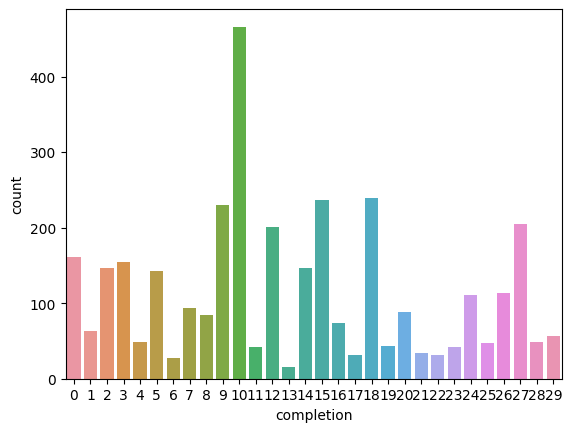

In [70]:
import seaborn as sns
ax = sns.countplot(x='completion', data = df_filtered_preprocessing)
print(df_filtered_preprocessing['completion'].value_counts())